# Adventure Works Cycles - Sales opportunities

<div class="alert alert-block alert-warning">
<b>About this project:</b> The goal of this project is to explore the Adventure Works database to identify opportunities for business enhancement through EDA (Exploratory Data Analysis).<br>
Adventure Works Cycles is a ficticious multinational manufacturing company, created by Microsoft for study purpose.<br>

<b>Findings:</b> to be registered 
</div>

## Project assumptions:
The ammount of sales opportunities will be represented by the sales quantity of each region and segment, when the result in (%) is below of the segment result (%) in total US sales.<br>
For the sake of study all the regions could perform the sales at the same segment mix of the total US sales.<br>

Granularity of data:<br>
Geographic: grouped by region | Date: group by month or year <br>

## Procedures
>1) Import libraries required <br>
>2) Import dataset (from local Microsoft SQL Server database).<br>
>3) Create the dataframes:<br>
    sales: result with region name, product segment, quantity, invoice value <br>
    population: US population quantity, grouped by region <br>
>4) Plot charts to explore data <br>
>5) Calculate the sales opportunities <br>
>6) Conclusion

### 1) Importing the libraries

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### 2) Connecting with SQL Server to get the data

In [2]:
connectiondata = (
    "Driver={SQL Server};"
    "Server=localhost\SQLEXPRESS;"
    "Database=AdventureWorks2019;"
    "Trusted_Connection=yes;")
## note to add when required; UID=login;PWD=senhadousuario)
connection = pyodbc.connect(connectiondata)
cursor = connection.cursor()

### 3) Creating the dataframes

In [3]:
# creating the sales dataframe 
query_sales = "SELECT CONVERT(DATE,SOH.OrderDate) AS 'OrderDate', SOH.SalesOrderID AS 'OrderID', PRP.Name AS 'Product', SOD.OrderQty AS 'Quantity', CAST(SOD.LineTotal AS DECIMAL(20,2)) AS 'InvoiceValue', PER.FirstName +' '+ PER.LastName AS 'CustomerName', PEA.City AS 'City', PSP.StateProvinceCode AS 'StateCode', PSP.Name AS 'StateName' FROM Sales.SalesOrderHeader SOH INNER JOIN SALES.SalesOrderDetail SOD ON SOH.SalesOrderID = SOD.SalesOrderID INNER JOIN Production.Product PRP ON SOD.ProductID = PRP.ProductID INNER JOIN Person.Person PER ON SOH.CustomerID = PER.BusinessEntityID INNER JOIN Person.Address PEA ON SOH.ShipToAddressID = PEA.AddressID INNER JOIN Person.StateProvince PSP ON PEA.StateProvinceID = PSP.StateProvinceID"
cursor.execute(query_sales)
connection = pyodbc.connect(connectiondata)
cursor = connection.cursor()
pyodbc.setDecimalSeparator(',')
dfsales = pd.read_sql(query_sales,connection,parse_dates={'SalesDate': {'format': '%Y-%m-%d'}})
dfsales = pd.DataFrame(dfsales)
dfsales.dtypes

OrderDate        object
OrderID           int64
Product          object
Quantity          int64
InvoiceValue    float64
CustomerName     object
City             object
StateCode        object
StateName        object
dtype: object

In [4]:
dfsales.info

<bound method DataFrame.info of         OrderDate  OrderID                  Product  Quantity  InvoiceValue  \
0      2011-05-31    43700       Road-650 Black, 62         1       69910.0   
1      2011-05-31    43701  Mountain-100 Silver, 44         1      339999.0   
2      2011-06-01    43703         Road-150 Red, 62         1      357827.0   
3      2011-06-01    43704   Mountain-100 Black, 48         1      337499.0   
4      2011-06-01    43705  Mountain-100 Silver, 38         1      339999.0   
...           ...      ...                      ...       ...           ...   
37919  2014-06-30    75122    Fender Set - Mountain         1        2198.0   
37920  2014-06-30    75122             AWC Logo Cap         1         899.0   
37921  2014-06-30    75123    Fender Set - Mountain         1        2198.0   
37922  2014-06-30    75123   All-Purpose Bike Stand         1       15900.0   
37923  2014-06-30    75123             AWC Logo Cap         1         899.0   

         CustomerNa

In [5]:
dfsales.tail(3)

,OrderDate,OrderID,Product,Quantity,InvoiceValue,CustomerName,City,StateCode,StateName
37921,2014-06-30,75123,Fender Set - Mountain,1,2198.0,Joshua Johnson,Sooke,BC,British Columbia
37922,2014-06-30,75123,All-Purpose Bike Stand,1,15900.0,Joshua Johnson,Sooke,BC,British Columbia
37923,2014-06-30,75123,AWC Logo Cap,1,899.0,Joshua Johnson,Sooke,BC,British Columbia


In [6]:
# loading the US population dataframe 
censusall = pd.read_excel(r'Data/Census_US_2010_2019.xlsx', skiprows = 5,nrows=4,header=None,usecols=(0,7)) #,header=None
censusall.columns = ['Region','Population']
print(censusall.head(10))
censusall.dtypes

      Region  Population
0  Northeast    56006011
1    Midwest    67745167
2      South   119624037
3       West    74925793


Region        object
Population     int64
dtype: object

In [7]:
# loading the list of states and regions
dfregion = pd.read_csv(r'Data/States_region.csv',sep=";",header=0)
dfregion=dfregion[['StateName','Region']]
print(dfregion.head())
print(dfregion.shape)
dfregion.dtypes

    StateName Region
0      Alaska   West
1     Alabama  South
2    Arkansas  South
3     Arizona   West
4  California   West
(51, 2)


StateName    object
Region       object
dtype: object

In [8]:
#insert the Region column into sales dataframe
dfsales2 = dfsales.merge(dfregion,on='StateName',how='right')
dfsales2 = dfsales2[dfsales2['Product'].notna()]
dfsales2.head()

,OrderDate,OrderID,Product,Quantity,InvoiceValue,CustomerName,City,StateCode,StateName,Region
1,2013-10-14,57966.0,Patch Kit/8 Patches,1.0,229.0,Alyssa Taylor,Birmingham,AL,Alabama,South
2,2014-06-12,74548.0,HL Mountain Tire,1.0,3500.0,Alyssa Taylor,Birmingham,AL,Alabama,South
5,2011-05-31,43700.0,"Road-650 Black, 62",1.0,69910.0,Bryan Gray,Beverly Hills,CA,California,West
6,2011-06-07,43726.0,"Road-650 Black, 58",1.0,69910.0,Sebastian Ramirez,Bellflower,CA,California,West
7,2011-06-18,43771.0,"Road-650 Red, 52",1.0,69910.0,Micheal Alvarez,Long Beach,CA,California,West


In [9]:
dfsales2['Year']= pd.DatetimeIndex(dfsales2["OrderDate"]).year

In [15]:
dfsales2.head(2)

,OrderDate,OrderID,Product,Quantity,InvoiceValue,CustomerName,City,StateCode,StateName,Region,Year
1,2013-10-14,57966.0,Patch Kit/8 Patches,1.0,229.0,Alyssa Taylor,Birmingham,AL,Alabama,South,2013
2,2014-06-12,74548.0,HL Mountain Tire,1.0,3500.0,Alyssa Taylor,Birmingham,AL,Alabama,South,2014


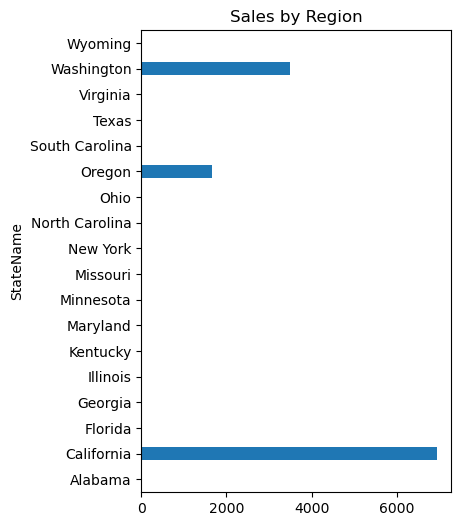

In [29]:
dfsales3 = dfsales2.groupby(['StateName'])['Quantity'].sum()
dfsales3.plot(kind='barh', title='Sales by Region',ylabel='Quantity',xlabel='StateName',figsize=(4, 6))
plt.show()

In [26]:
dfsales3

StateName
Alabama              2.0
California        6940.0
Florida              5.0
Georgia              7.0
Illinois             6.0
Kentucky             5.0
Maryland             4.0
Minnesota            3.0
Missouri             3.0
New York             7.0
North Carolina       2.0
Ohio                10.0
Oregon            1660.0
South Carolina       8.0
Texas               13.0
Virginia             2.0
Washington        3492.0
Wyoming              3.0
Name: Quantity, dtype: float64